# Tennis Event Data Figures Starter Notebook

## 1. Library Imports

In [1]:
import os
import numpy as np
import pandas as pd

# Matplotlib for drawing the court and shots
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.cm import get_cmap
from matplotlib.collections import LineCollection
import matplotlib.colors
from matplotlib.colors import to_rgba_array
from matplotlib.legend import Legend
from matplotlib.legend_handler import HandlerLineCollection
import matplotlib.patches as patches

from PIL import Image
import seaborn as sns

# Install this package if you dont have if already
from highlight_text import HighlightText, ax_text, fig_text

## 2. Helper Functions

In [2]:
def createTennisCourt(linecolor='white', ax=None, lw=1, alp=1, court_xlims=(-13,13), court_ylims=(-15,15)):
    '''
    Plots a Tennis Court with adjustable line colour, width and court limits
    '''
    if ax is None:
        ax = plt.gca()

    # Court Dimensions
    width_doub = 10.97
    width_sing = 8.23
    length_half = 11.89
    length_service = 6.4

    # Baseline Bottom
    ax.plot([-width_doub/2,width_doub/2], [-length_half]*2, color=linecolor, linewidth=lw, alpha=alp)
    # Baseline Top
    ax.plot([-width_doub/2,width_doub/2], [length_half]*2, color=linecolor, linewidth=lw, alpha=alp)
    # Horizontal Center Line
    ax.plot([-width_doub/2,width_doub/2], [0]*2, color=linecolor, linewidth=lw, alpha=alp)

    # Service Line Bottom
    ax.plot([-width_sing/2,width_sing/2], [-length_service]*2, color=linecolor, linewidth=lw, alpha=alp)
    # Service Line Top
    ax.plot([-width_sing/2,width_sing/2], [length_service]*2, color=linecolor, linewidth=lw, alpha=alp)


    ax.plot([-width_doub/2]*2, [-length_half,length_half], color=linecolor, linewidth=lw, alpha=alp)
    ax.plot([width_doub/2]*2, [-length_half,length_half], color=linecolor, linewidth=lw, alpha=alp)

    ax.plot([-width_sing/2]*2, [-length_half,length_half], color=linecolor, linewidth=lw, alpha=alp)
    ax.plot([width_sing/2]*2, [-length_half,length_half], color=linecolor, linewidth=lw, alpha=alp)

    ax.plot([0]*2, [-length_service,length_service], color=linecolor, linewidth=lw, alpha=alp)


    # ax.set_xlim(-width_doub/2-6.41,width_doub/2+6.41)
    # ax.set_ylim(-length_half-9,length_half+9)
    #plt.gca().invert_yaxis()

    ax.set_xlim(court_xlims)
    ax.set_ylim(court_ylims)

In [3]:
# For plotting lines in the "comet" style from mplsoccer (expanding width from start to end)
# More or less ripped straight from the mplsoccer package source code. Full credits to Andy Rowlinson (@numberstorm) et al.

def _create_segments(xstart, ystart, xend, yend, n_segments=100, multi_segment=False):
    if multi_segment:
        x = np.linspace(xstart, xend, n_segments + 1)
        y = np.linspace(ystart, yend, n_segments + 1)
        points = np.array([x, y]).T
        points = np.concatenate([points, np.expand_dims(points[:, -1, :], 1)], axis=1)
        points = np.expand_dims(points, 1)
        segments = np.concatenate([points[:, :, :-2, :],
                                   points[:, :, 1:-1, :],
                                   points[:, :, 2:, :]], axis=1)
        segments = np.transpose(segments, (0, 2, 1, 3)).reshape((-1, 3, 2))
    else:
        segments = np.transpose(np.array([[xstart, ystart], [xend, yend]]), (2, 0, 1))
    return segments

def _lines_no_cmap(xstart, ystart, xend, yend, lw=None, color=None, ax=None,
                n_segments=100, multi_segment=False, **kwargs):
    segments = _create_segments(xstart, ystart, xend, yend,
                                n_segments=n_segments, multi_segment=multi_segment)
    color = to_rgba_array(color)
    if (color.shape[0] > 1) and (color.shape[0] != xstart.size):
        raise ValueError("xstart and color must be the same size")
    line_collection = LineCollection(segments, color=color, linewidth=lw, snap=False, **kwargs)
    line_collection = ax.add_collection(line_collection)
    return line_collection

Let's create a simple tennis court.

In [7]:
# Set figure styling elements
import matplotlib as mpl

mpl.rcParams['axes.spines.bottom'] = False
mpl.rcParams['axes.spines.left'] = False
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False

mpl.rcParams['xtick.color'] = '#1f1f1f'
mpl.rcParams['xtick.labelsize'] = 13
mpl.rcParams['ytick.color'] = '#1f1f1f'
mpl.rcParams['ytick.labelsize'] = 13

mpl.rc('font', family='Calibri')

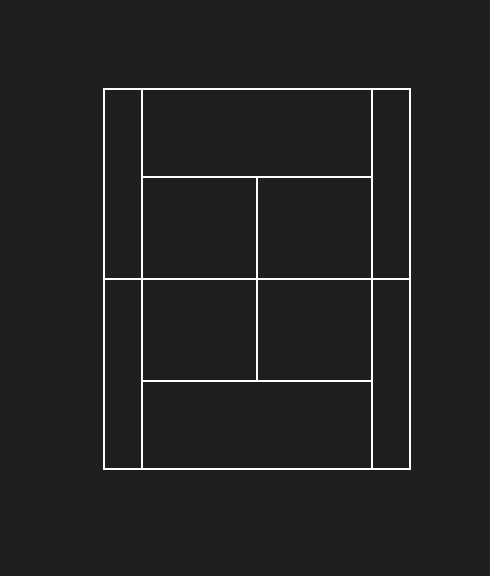

In [23]:
fig, ax = plt.subplots(1,1, figsize=(8, 10), facecolor="#1f1f1f", squeeze=True)
ax.set_facecolor("#1f1f1f")  
createTennisCourt(ax=ax, lw=2, court_xlims=(-8,8), court_ylims=(-17,17))

## 3. Read Data

In [10]:
df = pd.read_csv("events.csv")

In [11]:
# Plots will be made from the broadcast perspective of the server on the near side
# Here all indexes where the serve is made from the far-side are located, for data transformation
rows = [i for i in list(df.index) if df.Y.loc[i] > 0]
# Transform data to be near-side 
df.loc[rows, 'Y'] *=-1
df.loc[rows, 'Y2'] *=-1

df.loc[rows, 'X'] *=-1
df.loc[rows, 'X2'] *=-1

In [12]:
df.head()

,Set,Player1_Sets,Player2_Sets,Game,Player1_Game,Player2_Game,Tiebreak,Player1_Score,Player2_Score,Point,...,SP,Shot_Side,Shot_Type,X,Y,X2,Y2,Outcome,Remarks,Serve_Speed
0,1,0,0,1,0,0,0,0,0,1,...,0,FH,1st Serve,1.5,-12.0,-1.4,7.20,Fault,NaN,194
1,1,0,0,1,0,0,0,0,0,1,...,0,FH,2nd Serve,1.5,-11.9,-3.9,5.93,In-Play,NaN,135
2,1,0,0,1,0,0,0,0,0,1,...,0,BH,Topspin,7.0,-13.7,0.1,10.70,In-Play,NaN,NaN
3,1,0,0,1,0,0,0,0,0,1,...,0,FH,Topspin,0.8,-12.0,0.1,8.10,In-Play,NaN,NaN
4,1,0,0,1,0,0,0,0,0,1,...,0,FH,Topspin,-0.1,-13.7,3.3,9.40,In-Play,NaN,NaN


## 4. Plotting a Shot Map

Here we reproduce one of the figures in my blog post. Apologies if this isn't the simpliest example.

### Shot Plotting Utility Function

In [18]:
def plot_Rally_Shots(data1, data2, df, playerId, oppPlayerId, playerName, oppName, strokeTitle):
    '''
    Generic Rally Shots Plotter with splits into W/FE/UFEs/IndFE and Led to Point Won Outcomes

    Different to Return/Serve+1 Shots due to multiple shots per point included
    '''
    fig, ax = plt.subplots(1,2, figsize=(12, 9), facecolor="#1f1f1f", squeeze=False)
    
    #  Filter Shot Outcomes
    data_In = data1[(data1.Outcome.isin(["In-Play"]))]
    data_Win = data1[(data1.Outcome.isin(["Winner"]))]
    data_FE = data1[(data1.Outcome.isin(["Forced-Error"]))]
    data_UFE = data1[(data1.Outcome.isin(["Unforced-Error"]))]

    # Find data2 (opp) Forced Errors
    data_FE_opp = data2[(data2.Outcome.isin(["Forced-Error"]))]
    # Find data1 shots that induced a direct Forced-Error
    data_IndFE = data1[(data1.index.isin(data_FE_opp.index-1))]

    # Find Shot "Assists"
    # For Point Winning
    winner_idx = df[(df.Point_Winner==playerId) & (df.Outcome.isin(["Winner"]))].index-2
    wonErr_idx = df[(df.Point_Winner==playerId) & (df.Outcome.isin(["Forced-Error", "Unforced-Error"]))].index-3
    data_In_asstW = data_In[data_In.index.isin(list(winner_idx) + list(wonErr_idx))]
    # For Point Losing
    opp_winner_idx = df[(df.Point_Winner==oppPlayerId) & (df.Outcome.isin(["Winner"]))].index-1
    opp_wonErr_idx = df[(df.Point_Winner==oppPlayerId) & (df.Outcome.isin(["Forced-Error", "Unforced-Error"]))].index-2
    data_In_asstL = data_In[data_In.index.isin(list(opp_winner_idx) + list(opp_wonErr_idx))]

    # Compute who won the points played within the data subset
    pts_played = list(pd.unique(data1.Point))
    win_strokes = df.groupby('Point').last()
    win_strokes_played = win_strokes[win_strokes.index.isin(pts_played)]
    pts_won = win_strokes_played[win_strokes_played.Point_Winner == playerId]
    pts_won_perc = np.round(len(pts_won)*100/len(pts_played),1)
    print(win_strokes[win_strokes.index.isin(pts_played)].Point_Winner.value_counts())

    for j in range(2):
        createTennisCourt(ax=ax[0][j], lw=2, court_xlims=(-8,8), court_ylims=(-17,14.75))
        ax[0][j].set_facecolor("#1f1f1f")

    # For "Point-Ending" Shots
    clrs = ['#22AF4B', '#FEE851', '#EE224A', '#08B9A5']
    for i, data_p in enumerate([data_Win, data_FE, data_UFE, data_IndFE]):
        # Plot Line Segments
        _lines_no_cmap(data_p.X, data_p.Y, data_p.X2, data_p.Y2, lw=np.linspace(1,5,100), \
                    color=clrs[i], ax=ax[0][0], \
                    n_segments=100, multi_segment=True, alpha=0.3)
        ax[0][0].scatter(data_p.X2, data_p.Y2, zorder=10, \
        ec='w', s=60, c=clrs[i], alpha=0.7, lw=1)

    # Other Rally Shots
    clrs = ['#EEEEEE', '#1DA2DC', '#F05123']
    alp = [0.2, 0.7, 0.7]
    alp_l = [0.1, 0.3, 0.3]
    for i, data_p in enumerate([data_In, data_In_asstW, data_In_asstL]):
        # Plot Line Segments
        _lines_no_cmap(data_p.X, data_p.Y, data_p.X2, data_p.Y2, lw=np.linspace(1,5,100), \
                    color=clrs[i], ax=ax[0][1], \
                    n_segments=100, multi_segment=True, alpha=alp_l[i])
        ax[0][1].scatter(data_p.X2, data_p.Y2, zorder=10, \
        ec='w', s=60, c=clrs[i], alpha=alp[i], lw=1)

    # You can use the wrapper around the class
    HighlightText(x=0.09, y=0.92,
                s=f'{len(data1)} {strokeTitle} played in {len(pts_played)} points ({pts_won_perc}% won) \n<Winners ({len(data_Win)})>, <Forced-Errors ({len(data_FE)})>, <Unforced-Errors ({len(data_UFE)})>, <Induced a Forced-Error ({len(data_IndFE)})>, \n<Assisted a point-winning shot ({len(data_In_asstW)})> and <Assisted a point-losing shot ({len(data_In_asstL)})>.',
        highlight_textprops=[{"color": '#22AF4B', "weight": "bold",},
                            {"color": '#FEE851', "weight": "bold",},
                            {"color": '#EE224A', "weight": "bold",},
                            {"color": '#35B997', "weight": "bold",},
                            {"color": '#1DA2DC', "weight": "bold",},
                            {"color": '#F05123', "weight": "bold",},
                            ], fontsize=15, color='w', zorder=30,
        annotationbbox_kw={'boxcoords': fig.transFigure})
    
    # Figure Title
    # # Data source credit
    ax[0][0].annotate(f'{playerName}', (0.05, 0.975), xycoords = 'figure fraction', fontsize=28, color='w', ha='left', weight='bold')

    ax[0][0].annotate(f'vs {oppName} | Roland Garros 2022 Quarter Final', (0.05, 0.935), xycoords = 'figure fraction', fontsize=16, color='w', ha='left')
    ax[0][0].annotate('*Excluding Returns', (0.05, 0), xycoords = 'axes fraction', fontsize=15, color='w', ha='left')

    ax[0][1].annotate('Data: Self-collected', (0.95, 0), xycoords = 'axes fraction', fontsize=12, color='w', alpha=0.7, ha='right')
    ax[0][1].annotate('Made by @dlareg49', (0.95, -0.025), xycoords = 'axes fraction', fontsize=12, color='w', alpha=0.7, ha='right')

    plt.tight_layout()

    
    return fig

Let's plot Djokovic's Backhand Topspin shots.

2    74
1    52
Name: Point_Winner, dtype: int64


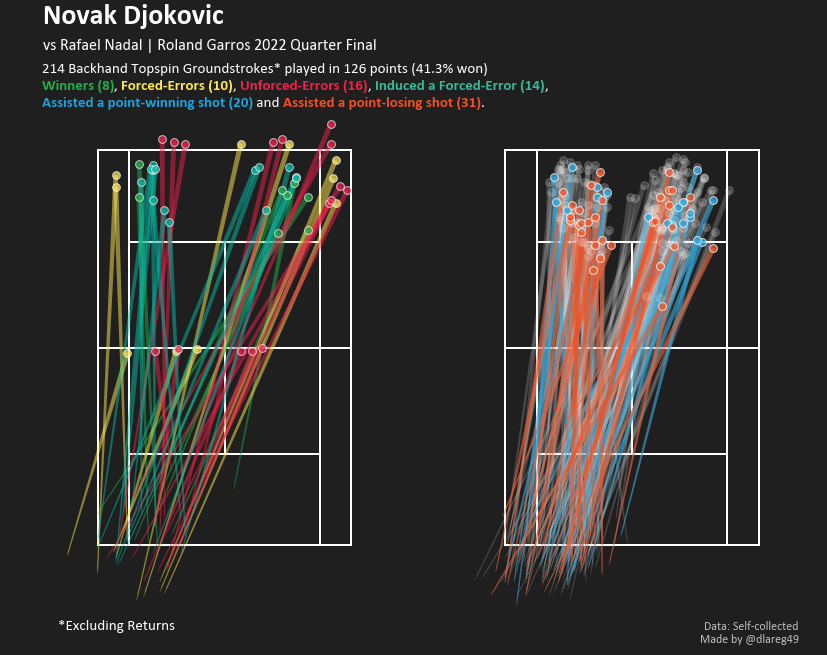

In [19]:
# Subset and Transform data to be plotted
data = df[(df.Player=="Player1")]
data_opp = df[(df.Player=="Player2")]
# Index of all opp serves
opp_serves_idx = data_opp[(data_opp.Shot_Type.isin(['1st Serve', '2nd Serve'])) & (data_opp.Outcome.isin(['In-Play']))].index

# Positional Filters for a FH Angled-CC Shot
data = data[(data.Shot_Side=="BH") & (data.Shot_Type.isin(["Topspin"]))]
# Remove Service Returns
data = data[~data.index.isin(opp_serves_idx+1)]

fig = plot_Rally_Shots(data, data_opp, df, "1", "2", "Novak Djokovic", "Rafael Nadal", "Backhand Topspin Groundstrokes*")

In [17]:
fig.savefig('Djokovic_BH.png', bbox_inches='tight', dpi=150, facecolor=fig.get_facecolor())